In [1]:
import copy
import importlib
import os
import warnings
from itertools import product

import torch
from dotenv import load_dotenv
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.tuner import Tuner
from tqdm.auto import tqdm

load_dotenv("../env")

warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [2]:
import luminar.document.data
import luminar.document.model
import luminar.features
import luminar.mongo

importlib.reload(luminar.document.data)
importlib.reload(luminar.document.model)
importlib.reload(luminar.features)
importlib.reload(luminar.mongo)

<module 'luminar.mongo' from '/nvme/projects/PrismAI/PrismAI/src/luminar/mongo.py'>

In [3]:
from luminar.document.data import (
    DocumentClassificationDataModule,
    FeatureDataset,
    PaddingDataloader,
    n_way_split,
)
from luminar.document.model import ConvolutionalLayerSpec, DocumentClassficationModel
from luminar.features import FeatureExtractor, OneDimFeatures, Slicer, TwoDimFeatures
from luminar.mongo import MongoDataset

In [4]:
config = {
    "seed": 1337,
    "eval_split": 0.1,
    "test_split": 0.1,
    "feature_model": "gpt2",
}

In [5]:
sources = [
    "ieee-chatgpt-generation.jsonl",
    "ieee-chatgpt-polish.jsonl",
    "ieee-chatgpt-fusion.jsonl",
    # "ieee-init.jsonl",
]

In [6]:
datasets = {}
for source in tqdm(sources):
    dataset = MongoDataset(
        mongo_db_connection=os.environ.get("MONGO_DB_CONNECTION"),
        database="prismai",
        collection="features_CHEAT",
        pipeline=[
            {
                "$lookup": {
                    "from": "dataset_CHEAT",
                    "as": "document.source",
                    "localField": "document._id.$id",
                    "foreignField": "_id",
                }
            },
            {
                "$unwind": "$document.source",
            },
            {
                "$match": {
                    # "document.source.source": source,
                    "document.source.source": {"$in": ["ieee-init.jsonl", source]},
                }
            },
            {
                "$group": {
                    "_id": "$document.source.id",
                    "features": {
                        "$push": {
                            "label": "$document.label",
                            "source": "$document.source.source",
                            "type": "$document.type",
                            "split": "$split",
                            "transition_scores": "$transition_scores",
                        }
                    },
                }
            },
        ],
    ).load()
    datasets[source] = dataset

  0%|          | 0/3 [00:00<?, ?it/s]

[MongoDataset] Loading Data from Cache File /tmp/luminar/97ea3707c420acfb660be595429e3076beb11aef5101a61f2792f18b7f3595a5.pkl
[MongoDataset] Loading Data from Cache File /tmp/luminar/7dcafc7afd73568978a04f52e505d1bf15d45e89d0f776c51fc59fc7ea4d1ff0.pkl
[MongoDataset] Loading Data from Cache File /tmp/luminar/5bdf271ea22922bac2ed3ac86b526c386452f9841323bc2819f61e1b85ef011d.pkl


In [7]:
train_splits = {}
eval_splits = {}
test_splits = {}
for ai_counterpart, dataset in datasets.items():
    seed_everything(config["seed"])
    train_dataset, eval_dataset, test_dataset = n_way_split(
        dataset,
        config["eval_split"],
        config["test_split"],
        infer_first=True,
    )
    train_splits[ai_counterpart] = train_dataset
    eval_splits[ai_counterpart] = eval_dataset
    test_splits[ai_counterpart] = test_dataset

Seed set to 1337
Seed set to 1337
Seed set to 1337


In [24]:
feature_dim = OneDimFeatures(128)
featurizer = FeatureExtractor.Likelihood()
# featurizer = FeatureExtractor.LogLikelihoodLogRankRatio()
config["second_dim_as_channels"] = False
# feature_dim = TwoDimFeatures(128, 13)
# featurizer = FeatureExtractor.LikelihoodTopkLikelihoodRatio(13)
# featurizer = FeatureExtractor.IntermediateLogits(13)
# config["second_dim_as_channels"] = True

# slicer = Slicer.First(feature_dim[0])
# slicer = Slicer.Random(feature_dim[0])
slicer = Slicer.RandomMultiple(feature_dim[0] // 4, multiple=4, stride=16)
# slicer = Slicer.RandomMultiple(feature_dim[0] // 4, 4)

config["feature_dim"] = feature_dim
config["featurizer"] = repr(featurizer)
config["slicer"] = repr(slicer)

config["num_samples"] = None


def featurize(dataset) -> FeatureDataset:
    return FeatureDataset(
        tqdm(dataset, desc="Featurizing", leave=False),
        slicer,
        featurizer,
        num_samples=config["num_samples"],
        label_field="label",
        label_zero="human",
    )

In [25]:
train_datasets, eval_datasets, test_datasets = {}, {}, {}
for ai_counterpart, dataset in tqdm(datasets.items()):
    train_datasets[ai_counterpart] = featurize(train_splits[ai_counterpart])
    eval_datasets[ai_counterpart] = featurize(eval_splits[ai_counterpart])
    test_datasets[ai_counterpart] = featurize(test_splits[ai_counterpart])

  0%|          | 0/3 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/12317 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/12317 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/12317 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1539 [00:00<?, ?it/s]

## In-Domain Training & Evaluation

In [26]:
config |= {
    "projection_dim": None,
    "learning_rate": 0.0002,
    "warmup_steps": 150,
    "max_epochs": 50,
    "gradient_clip_val": 1.0,
    "batch_size": 128,
}

# SeqXGPT Layer Configuration
config["conv_layer_shapes"] = [
    ConvolutionalLayerSpec(64, 5),
    *[ConvolutionalLayerSpec(128, 3)] * 3,
    ConvolutionalLayerSpec(64, 3),
]

In [27]:
from torch.utils.data import ConcatDataset


# capturing config from "closure"
def get_dataloader(*dataset, **kwargs) -> PaddingDataloader:
    if len(dataset) == 1:
        dataset = dataset[0]
    else:
        dataset = ConcatDataset(dataset)
    return PaddingDataloader(
        dataset,
        feature_dim=config["feature_dim"],
        batch_size=config["batch_size"],
        **kwargs,
    )

In [28]:
results_in_domain = {}
for ai_counterpart in sources:
    seed_everything(config["seed"])

    train_dataloader = get_dataloader(train_datasets[ai_counterpart], shuffle=True)
    eval_dataloader = get_dataloader(eval_datasets[ai_counterpart])

    model = DocumentClassficationModel(**config)
    trainer = Trainer(
        max_epochs=config["max_epochs"],
        logger=pl_loggers.TensorBoardLogger(
            save_dir=f"logs/CHEAT/{type(featurizer).__name__}",
        ),
        gradient_clip_val=config["gradient_clip_val"],
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
        deterministic=True,
    )

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=eval_dataloader,
    )

    trainer.progress_bar_callback.disable()
    metrics = []
    for other, dataset in test_datasets.items():
        trainer.validate(
            model, get_dataloader(eval_datasets[other]), verbose=False
        )
        metrics.append(
            {
                "other": other,
            }
            | trainer.test(
                model,
                get_dataloader(dataset),
                verbose=False,
            )[0]
        )
    trainer.progress_bar_callback.enable()

    results_in_domain[ai_counterpart] = {
        "domain": ai_counterpart,
        "config": copy.deepcopy(config),
        "metrics": metrics,
    }
    print(ai_counterpart, metrics)


Seed set to 1337
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes   | Out sizes 
------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 148 K  | train | ?          | ?         
1 | projection  | Identity          | 0      | train | [32, 8192] | [32, 8192]
2 | classifier  | Linear            | 8.2 K  | train | [32, 8192] | [32, 1]   
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?          | ?

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


ieee-chatgpt-generation.jsonl [{'other': 'ieee-chatgpt-generation.jsonl', 'test_loss': 0.3590863347053528, 'test_acc@0.5': 0.8427914381027222, 'test_acc@best': 0.8506518602371216, 'test_roc_auc': 0.9264601469039917}, {'other': 'ieee-chatgpt-polish.jsonl', 'test_loss': 0.7697647213935852, 'test_acc@0.5': 0.6315286159515381, 'test_acc@best': 0.6508513689041138, 'test_roc_auc': 0.6882583498954773}, {'other': 'ieee-chatgpt-fusion.jsonl', 'test_loss': 0.7996882200241089, 'test_acc@0.5': 0.6363333463668823, 'test_acc@best': 0.7039999961853027, 'test_roc_auc': 0.6149265766143799}]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes   | Out sizes 
------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 148 K  | train | ?          | ?         
1 | projection  | Identity          | 0      | train | [32, 8192] | [32, 8192]
2 | classifier  | Linear            | 8.2 K  | train | [32, 8192] | [32, 1]   
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?          | ?         
-------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


ieee-chatgpt-polish.jsonl [{'other': 'ieee-chatgpt-generation.jsonl', 'test_loss': 0.5336413979530334, 'test_acc@0.5': 0.7337039709091187, 'test_acc@best': 0.7808665633201599, 'test_roc_auc': 0.8456644415855408}, {'other': 'ieee-chatgpt-polish.jsonl', 'test_loss': 0.6139809489250183, 'test_acc@0.5': 0.6617562770843506, 'test_acc@best': 0.6766787767410278, 'test_roc_auc': 0.7239168286323547}, {'other': 'ieee-chatgpt-fusion.jsonl', 'test_loss': 0.8314019441604614, 'test_acc@0.5': 0.4896666705608368, 'test_acc@best': 0.706333339214325, 'test_roc_auc': 0.6233289837837219}]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes   | Out sizes 
------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 148 K  | train | ?          | ?         
1 | projection  | Identity          | 0      | train | [32, 8192] | [32, 8192]
2 | classifier  | Linear            | 8.2 K  | train | [32, 8192] | [32, 1]   
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?          | ?         
-------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ieee-chatgpt-fusion.jsonl [{'other': 'ieee-chatgpt-generation.jsonl', 'test_loss': 0.6899405121803284, 'test_acc@0.5': 0.49463191628456116, 'test_acc@best': 0.7641870975494385, 'test_roc_auc': 0.8210964798927307}, {'other': 'ieee-chatgpt-polish.jsonl', 'test_loss': 0.7829623818397522, 'test_acc@0.5': 0.4339008927345276, 'test_acc@best': 0.6563994884490967, 'test_roc_auc': 0.6832153797149658}, {'other': 'ieee-chatgpt-fusion.jsonl', 'test_loss': 0.5840380191802979, 'test_acc@0.5': 0.7066666483879089, 'test_acc@best': 0.7070000171661377, 'test_roc_auc': 0.6287767887115479}]


In [29]:
import pandas as pd

results = []
for ai_counterpart in sources:
    results.append(
        [
            results_in_domain[ai_counterpart]["metrics"][i]["test_roc_auc"]
            for i in range(len(sources))
        ]
    )

df = pd.DataFrame(results, columns=sources, index=sources)
df

,ieee-chatgpt-generation.jsonl,ieee-chatgpt-polish.jsonl,ieee-chatgpt-fusion.jsonl
ieee-chatgpt-generation.jsonl,0.926460,0.688258,0.614927
ieee-chatgpt-polish.jsonl,0.845664,0.723917,0.623329
ieee-chatgpt-fusion.jsonl,0.821096,0.683215,0.628777


## Cross-Domain Training & Evaluation

In [30]:
seed_everything(config["seed"])
train_dataloader = get_dataloader(*train_datasets.values(), shuffle=True)
eval_dataloader = get_dataloader(*eval_datasets.values())
test_dataloader = get_dataloader(*test_datasets.values())

model = DocumentClassficationModel(**config)
trainer = Trainer(
    max_epochs=config["max_epochs"],
    logger=pl_loggers.TensorBoardLogger(
        save_dir=f"logs/all_domains/{type(featurizer).__name__}",
    ),
    gradient_clip_val=config["gradient_clip_val"],
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
    deterministic=True,
)
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=eval_dataloader,
)

Seed set to 1337
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes   | Out sizes 
------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 148 K  | train | ?          | ?         
1 | projection  | Identity          | 0      | train | [32, 8192] | [32, 8192]
2 | classifier  | Linear            | 8.2 K  | train | [32, 8192] | [32, 1]   
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?          | ?

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [31]:
trainer.progress_bar_callback.disable()
metrics_cross_domain = []
for other, dataset in test_datasets.items():
    trainer.validate(model, get_dataloader(eval_datasets[ai_counterpart]), verbose=False)
    metrics_cross_domain.append(
        {"other": other}
        | trainer.test(
            model,
            get_dataloader(dataset),
            verbose=False,
        )[0]
    )
trainer.validate(model, eval_dataloader, verbose=False)
metrics_cross_domain += [
    {
        "other": "ALL",
        **trainer.test(
            model,
            test_dataloader,
            verbose=False,
        )[0],
    }
]
trainer.progress_bar_callback.enable()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [32]:
import pandas as pd


def df_to_latex_heatmap(_df: pd.DataFrame):
    print(
        "\\plotHeatmap{"
        + ",".join(_df.index)
        + "}{%\n    "
        + ",%\n    ".join(
            [
                "{"
                + ",".join(f"{val:.4f}/{round(val, 2):.2f}" for val in row[1:])
                + "}"
                for row in _df.reset_index().values
            ]
        )
        + "%\n}{"
        + ",".join(_df.columns)
        + "}"
    )


In [33]:
_metric = "test_roc_auc"
# _metric = "test_acc@best"

results = []
for ai_counterpart in sources:
    results.append(
        [
            results_in_domain[ai_counterpart]["metrics"][i][_metric]
            for i in range(len(sources))
        ]
    )
results.append([m[_metric] for m in metrics_cross_domain[:len(sources)]])

df = pd.DataFrame(results, columns=sources, index=list(sources) + ["ALL"])
df["AVG"] = df.mean(axis=1)
df["AVG"][-1] = metrics_cross_domain[-1][_metric]
df

/tmp/ipykernel_1303452/1923075231.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["AVG"][-1] = metrics_cross_domain[-1][_metric]
/tmp/ipykernel_1303452/1923075231.py:16: FutureWarning: Series.__setitem__ treating keys as positions is

,ieee-chatgpt-generation.jsonl,ieee-chatgpt-polish.jsonl,ieee-chatgpt-fusion.jsonl,AVG
ieee-chatgpt-generation.jsonl,0.926460,0.688258,0.614927,0.743215
ieee-chatgpt-polish.jsonl,0.845664,0.723917,0.623329,0.730970
ieee-chatgpt-fusion.jsonl,0.821096,0.683215,0.628777,0.711030
ALL,0.916595,0.723028,0.633082,0.796769


In [34]:
df_to_latex_heatmap(df)

\plotHeatmap{ieee-chatgpt-generation.jsonl,ieee-chatgpt-polish.jsonl,ieee-chatgpt-fusion.jsonl,ALL}{%
    {0.9265/0.93,0.6883/0.69,0.6149/0.61,0.7432/0.74},%
    {0.8457/0.85,0.7239/0.72,0.6233/0.62,0.7310/0.73},%
    {0.8211/0.82,0.6832/0.68,0.6288/0.63,0.7110/0.71},%
    {0.9166/0.92,0.7230/0.72,0.6331/0.63,0.7968/0.80}%
}{ieee-chatgpt-generation.jsonl,ieee-chatgpt-polish.jsonl,ieee-chatgpt-fusion.jsonl,AVG}


In [35]:
config

{'seed': 1337,
 'eval_split': 0.1,
 'test_split': 0.1,
 'feature_model': 'gpt2',
 'second_dim_as_channels': False,
 'feature_dim': OneDimFeatures(size=128),
 'featurizer': 'Likelihood()',
 'slicer': 'SliceRandomMultiple(size=32, multiple=4, stride=16, sort=False)',
 'num_samples': None,
 'projection_dim': None,
 'learning_rate': 0.0002,
 'warmup_steps': 150,
 'max_epochs': 50,
 'gradient_clip_val': 1.0,
 'batch_size': 128,
 'conv_layer_shapes': [(64, 5, 1),
  (128, 3, 1),
  (128, 3, 1),
  (128, 3, 1),
  (64, 3, 1)]}

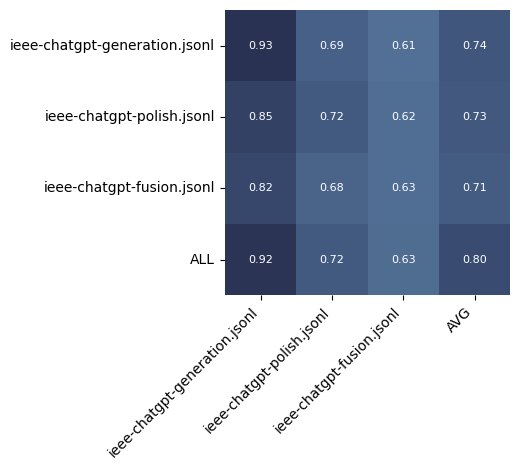

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    vmax=1.0,
    vmin=0.0,
    cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True),
    yticklabels=list(sources) + ["ALL"],
    xticklabels=list(sources) + ["AVG"],
    square=True,
    # reduce annotation font size
    annot_kws={"fontsize": 8},
    cbar=False,
)

# rotate x-axis labels by 45 degrees
# anchored at the right edge of the axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

plt.tight_layout()
# plt.savefig(
#     "../figures/evaluation-trained_in_domain-test_0.1-gpt2_256-rand_4-il_13_as_channels.pdf",
#     dpi=300,
# )
plt.show()

### LLR on Whole Datasets

In [40]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores
from simple_dataset import Dataset as SimpleDataset
from transition_scores.data import TransitionScores

results_llr = []
for ai_counterpart, split in datasets.items():
    dataset_test = (
        SimpleDataset(split)
        .flat_map(lambda doc: doc["features"])
        .map(
            lambda x: {
                "llr": llr_from_transition_scores(
                    TransitionScores(**x["transition_scores"])
                ),
                "labels": int(x["label"] != "human"),
            },
            in_place=False,
        )
    )
    fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
    auroc = auc(fpr, tpr)

    preds = np.array(dataset_test["llr"])
    labels = np.array(dataset_test["labels"])

    mean_0 = float(np.mean(preds[labels == 0]))
    mean_1 = float(np.mean(preds[labels == 1]))

    thresholds = np.linspace(round(mean_0, 1) - 0.2, round(mean_1, 1) + 0.3, 5001)
    preds_thresholded: np.ndarray = preds > thresholds.reshape(-1, 1)
    acc_thresholded = np.mean((preds_thresholded == labels), axis=1)
    idx = np.argmax(acc_thresholded)
    best_threshold = thresholds[idx]
    best_acc = acc_thresholded[idx]

    results_llr.append({
        "domain": ai_counterpart,
        "auroc": auroc,
        "best_acc": best_acc,
        "best_threshold": best_threshold,
    })

pd.DataFrame(results_llr)

,domain,auroc,best_acc,best_threshold
0,ieee-chatgpt-generation.jsonl,0.883773,0.813153,1.88522
1,ieee-chatgpt-polish.jsonl,0.688137,0.656438,1.83970
2,ieee-chatgpt-fusion.jsonl,0.625874,0.703247,2.19300


### LLR on Test Splits

In [41]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores
from simple_dataset import Dataset as SimpleDataset
from transition_scores.data import TransitionScores

results_llr = []
for ai_counterpart, split in test_splits.items():
    dataset_test = (
        SimpleDataset(split)
        .flat_map(lambda doc: doc["features"])
        .map(
            lambda x: {
                "llr": llr_from_transition_scores(
                    TransitionScores(**x["transition_scores"])
                ),
                "labels": int(x["label"] != "human"),
            },
            in_place=False,
        )
    )
    fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
    auroc = auc(fpr, tpr)

    preds = np.array(dataset_test["llr"])
    labels = np.array(dataset_test["labels"])

    mean_0 = float(np.mean(preds[labels == 0]))
    mean_1 = float(np.mean(preds[labels == 1]))

    thresholds = np.linspace(round(mean_0, 1) - 0.2, round(mean_1, 1) + 0.3, 1001)
    preds_thresholded: np.ndarray = preds > thresholds.reshape(-1, 1)
    acc_thresholded = np.mean((preds_thresholded == labels), axis=1)
    idx = np.argmax(acc_thresholded)
    best_threshold = thresholds[idx]
    best_acc = acc_thresholded[idx]

    results_llr.append({
        "domain": ai_counterpart,
        "auroc": auroc,
        "best_acc": best_acc,
        "best_threshold": best_threshold,
    })

pd.DataFrame(results_llr)

,domain,auroc,best_acc,best_threshold
0,ieee-chatgpt-generation.jsonl,0.892428,0.823811,1.896
1,ieee-chatgpt-polish.jsonl,0.691907,0.661374,1.830
2,ieee-chatgpt-fusion.jsonl,0.627652,0.710667,2.115


In [39]:
raise RuntimeError("STOP")

RuntimeError: STOP

In [ ]:
sample = train_dataset[0]["features"].numpy().squeeze()
train_dataset[0]["labels"]

In [ ]:
fig = plt.imshow(sample.T, cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True))
fig.axes.set_axis_off()
plt.show()

In [ ]:
sample = train_dataset[2]["features"].numpy().squeeze()
train_dataset[2]["labels"]

In [ ]:
fig = plt.imshow(sample.T, cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True))
fig.axes.set_axis_off()
plt.show()

In [ ]:
raise RuntimeError("STOP")

In [ ]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores

dataset_test = dm._dataset_test.map(
    lambda x: {
        "llr": llr_from_transition_scores(x["features"]),
        "labels": x["labels"],
    },
    in_place=False,
)
fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
auc(fpr, tpr)